# Miniproject 2 - Part 1

Reminders:

In this case, the rows (0th dimension) represents the number of data points in time. The columns (or 1st dimension) represents the number of channels in each data point.

most EMG signals concentrate in frequencies lower than 500Hz. 

In [43]:
import numpy as np
from numpy.fft import rfft, irfft
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import pandas as pd
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.signal import stft

from statsmodels.regression.linear_model import yule_walker

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## 1) Loading, visualizing & Preprocessing

Steps:
- load
- denoising (bandpass to isolate freq of interest) --> butterworth filter with cutoff frequencies at 5Hz and 500Hz

acquired signal might contain noticeable powergrid noise. The powergrid operates at 50Hz in Europe (60Hz in the US and Japan). if it is significant, it is necessary to filter it out using a bandstop filter. Depending on the strength of the powergrid noise, you might need to filter the harmonics of it (the integer multiples of 50Hz +- 2Hz). 

In [2]:
# Sampling frequency (Hz)
fs = 100 # found in paper (see below)

# load EMG data
EMG_file_name='./s2/S2_A1_E1.mat'
data = loadmat(EMG_file_name)

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])


In Acquisition setup:

"Data from the CyberGlove were transmitted over a Bluetooth-tunneled serial port at slightly less than 25 Hz; data from the inclinometer, the FFLS and the Otto-Bock sEMG electrodes were acquired at **100 Hz** using a National Instruments data acquisition card (NI-DAQ PCMCIA 6024E, 12-bit resolution); the Delsys base station received the sEMG and accelerometer streams via an ad-hoc wireless network and relayed the data via a standard USB connection"

Source : https://www.nature.com/articles/sdata201453

For each subject and exercise, the database contains one file in Matlab format (www.mathworks.com) with synchronized variables. The variables included in the files are:

- subject (n° of subject)
- exercise (n° of exercise done)
- stimulus (1 column): the original label of the movement repeated by the subject;
- emg --> sEMG signal of the electrodes; columns 1–8 include the signal from the electrodes equally spaced around the forearm; columns 9 and 10 include the signal from the electrodes located on the main activity spots of the muscle Flexor Digitorum Superficialis and of the muscle Extensor Digitorum Superficialis14; when available, columns 11 and 12 include the signal from the main activity spots of the muscle Biceps Brachii and of the muscle Triceps Brachii; (Shape: (number_timepoints, number_channels) = emg.shape)
- glove (22 columns): uncalibrated signal from the 22 sensors of the Cyberglove. The raw data are declared to be proportional to the angles of the joints in the CyberGlove manual; details on the location of the sensors are available at the link: ninapro.hevs.ch/node/123;
- restimulus (1 column): the a-posteriori refined label of the movement;
- repetition (1 column): stimulus repetition index;
- rerepetition (1 column): restimulus repetition index;

Source : https://www.nature.com/articles/sdata201453

In [3]:
emg = data['emg']
data_shape = emg.shape
number_timepoints = emg.shape[0]
number_channels = emg.shape[1]

print(f'The shape of the data is {data_shape}')
print(f'There are {number_timepoints} timepoints')
print(f'There are {number_channels} channels')

The shape of the data is (100686, 10)
There are 100686 timepoints
There are 10 channels


In [4]:
# Extract labels
labels = data['restimulus'].flatten()

# Extract repetition indices
repetition = data['rerepetition'].flatten()

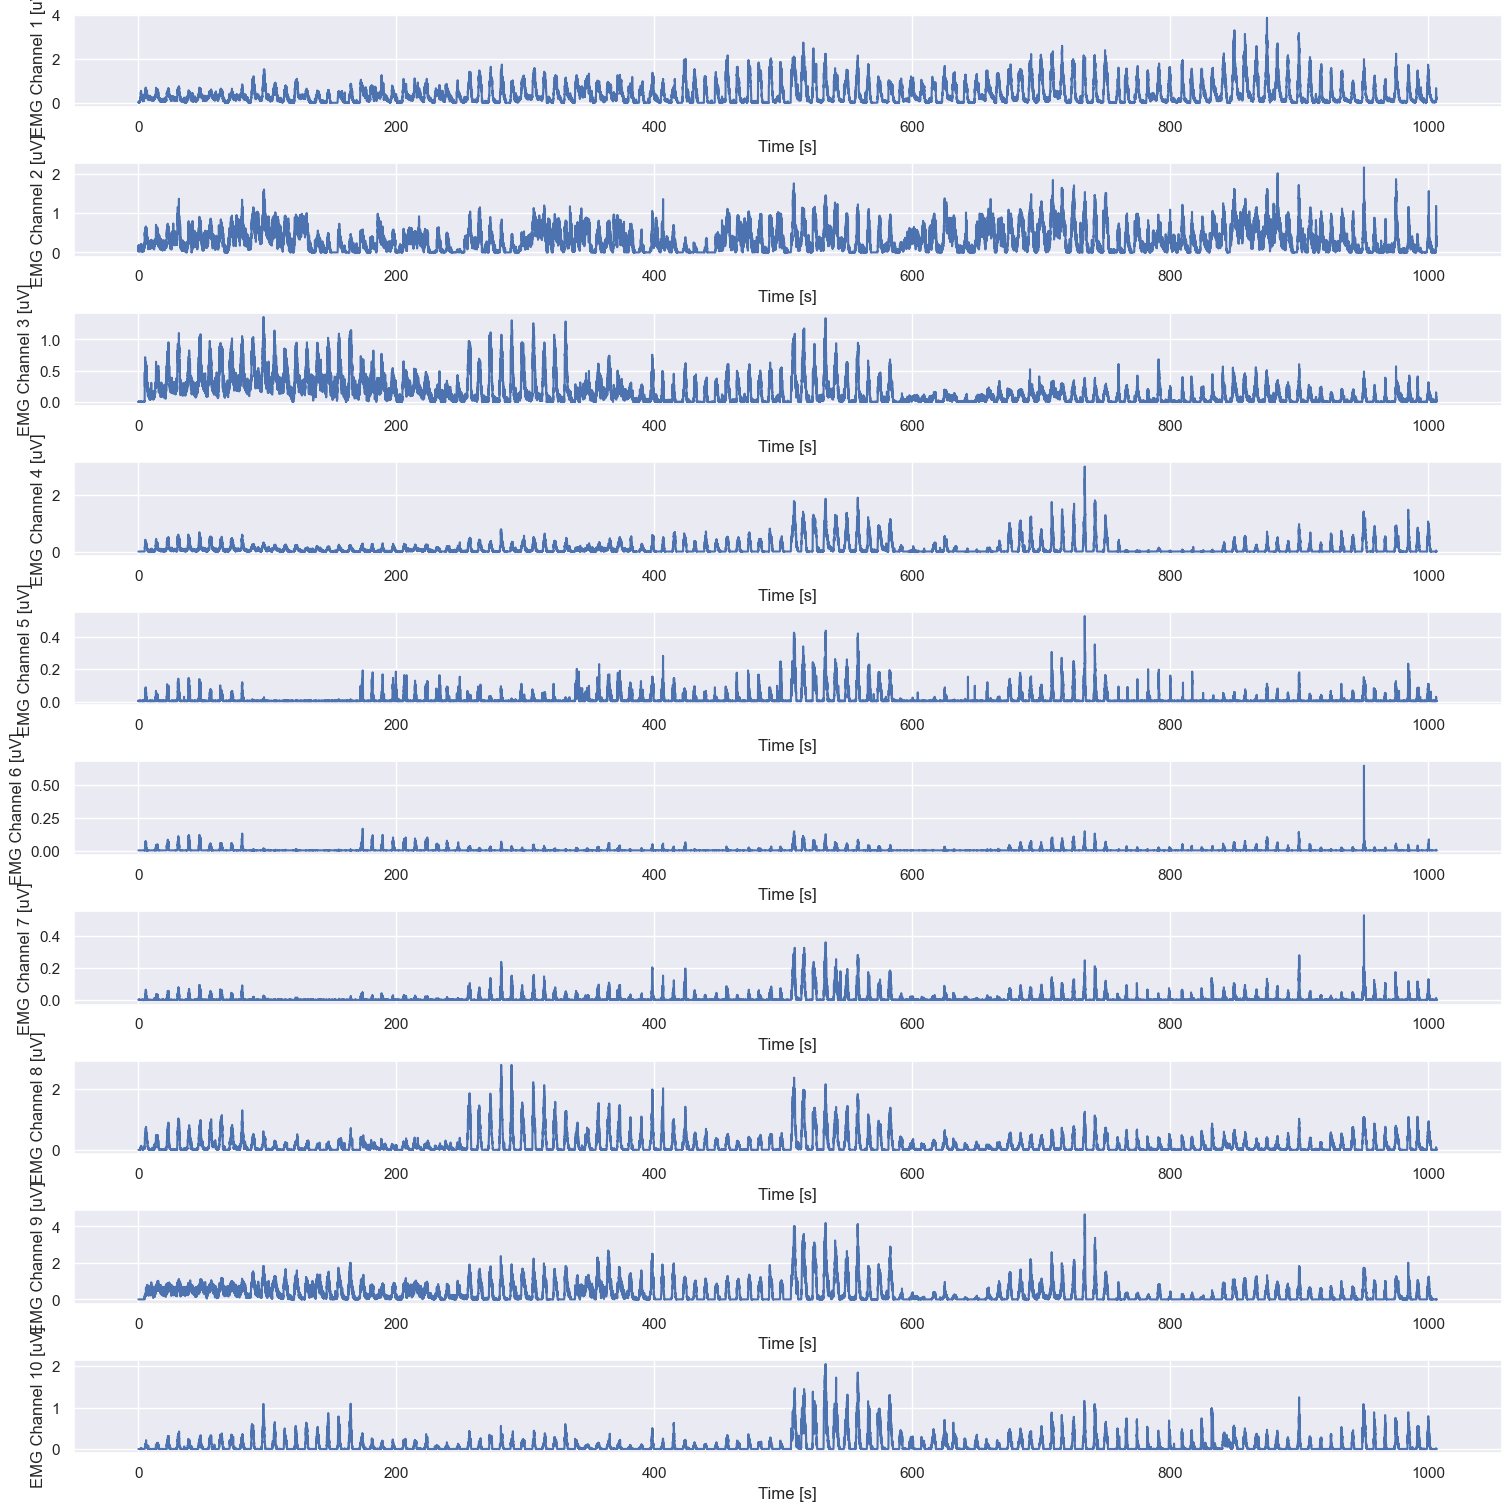

In [5]:
# Visualization of raw EMG signals

time_steps = np.arange(0, number_timepoints/fs, 1/fs)

fig, ax = plt.subplots(number_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(number_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"EMG Channel {channel_idx + 1} [uV]")

plt.show()

In [6]:
# PREPROCESSING:

# Apply bandpass filter between 10 Hz and 45 Hz --> depends on sampling freq

bandpass_cutoff_frequencies_Hz = (10, 45)
sos = butter(N=4, Wn=np.array(bandpass_cutoff_frequencies_Hz) / (fs / 2), btype="bandpass", output="sos")
emg_filtered = sosfiltfilt(sos, emg, axis=0)

According to the Nyquist theorem, the maximum frequency that can be accurately represented without aliasing is half the sampling frequency : 

fe = fsamp/2 = 100/2 = 50 Hz

- **Upper cutoff freq:** must be below fe (avoid aliasing)
- **Lower cutoff freq:** must be approx. above 10 Hz (avoid artifacts) BUT some muscle activation signals can contain useful informaiton starting around 5 Hz --> **5 or 10 Hz????**

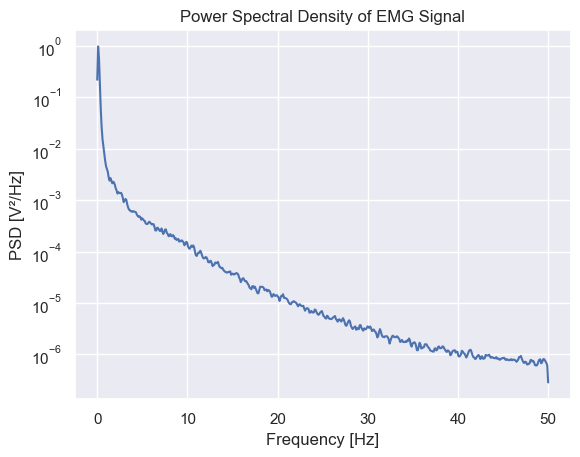

In [7]:
# plot freq spectrum of EMG signals using power spectral density estimates (Welch) --> see where signal energy = concentrated
# to decide if lower cutoff freq = 5 or 10 Hz
freqs, psd = welch(emg[:, 0], fs=fs, nperseg=1024)
plt.semilogy(freqs, psd)
plt.title('Power Spectral Density of EMG Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V²/Hz]')
plt.show()

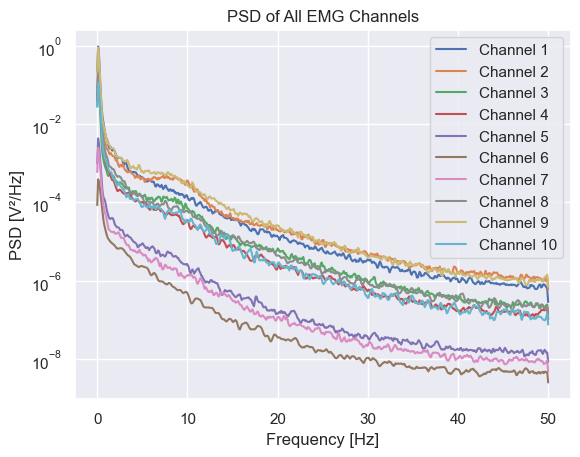

In [8]:
# Examine the PSD of multiple channels to see if it's a common pattern or issues w/spe electrodes

for i in range(number_channels):
    freqs, psd = welch(emg[:, i], fs=fs, nperseg=1024)
    plt.semilogy(freqs, psd, label=f'Channel {i+1}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V²/Hz]')
plt.title('PSD of All EMG Channels')
plt.legend()
plt.show()

it seems like all channels show the same pattern, with channels 2 and 9 showing an additional bump at approx. f = 8-9 Hz. this could correspond to artifacts. therefore I think setting the lower cutoff at **10 Hz** might be a better idea since it seems like for all the channels the remaining frequencies still carry enough info when f > 10 Hz.

"signals were cleaned from 50 Hz (and harmonics) power-line interference using a Hampel filter." - paper on electromyo data for non-invasive blablabla

In [26]:
# powergrid noise???????

# not possible to filter 50 Hz noise (= powerline noise in Europe)
# bc it sits at Nyquist frequency & freq at or beyond it are not properly
# represented (aliasing) ==> NOT A PROBLEM FOR THIS DATASET!!!

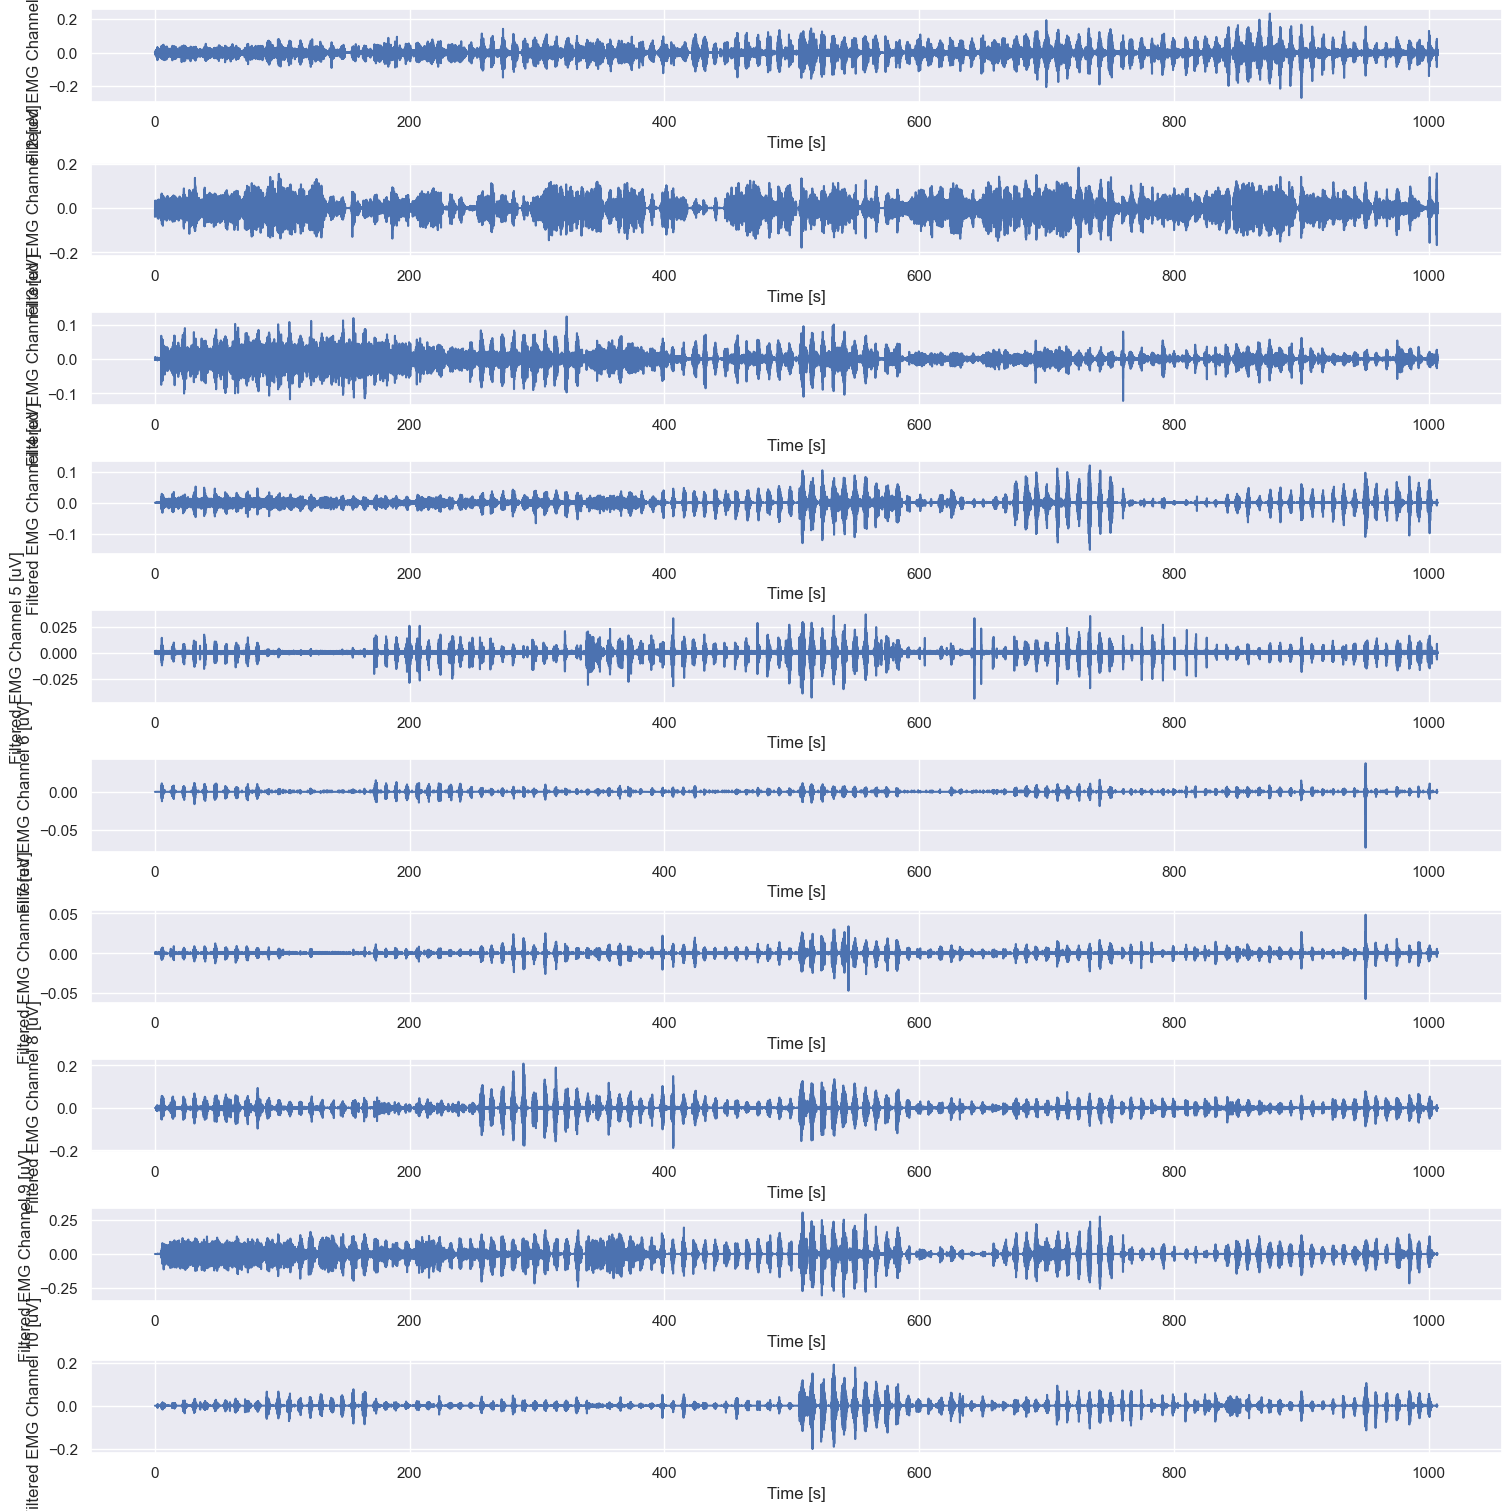

In [9]:
# Visualization of filtered EMG signals

fig, ax = plt.subplots(number_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(number_channels):
    ax[channel_idx].plot(time_steps, emg_filtered[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"Filtered EMG Channel {channel_idx + 1} [uV]")

plt.show()

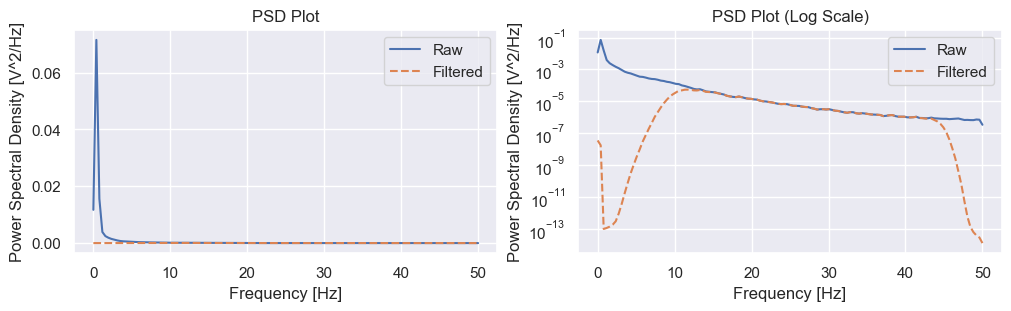

In [13]:
# Use Welch's method for power spectral density estimation (it changed after filtering), it reduces the variance of the estimate.

freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=256)
freqs_post, Pxx_post = welch(emg_filtered[:, 0], fs=fs, nperseg=256)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="Raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="Filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density [V^2/Hz]")
ax[0].set_title("PSD Plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="Raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="Filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density [V^2/Hz]")
ax[1].set_title("PSD Plot (Log Scale)")
plt.show()

## how to interpret these graphs???????

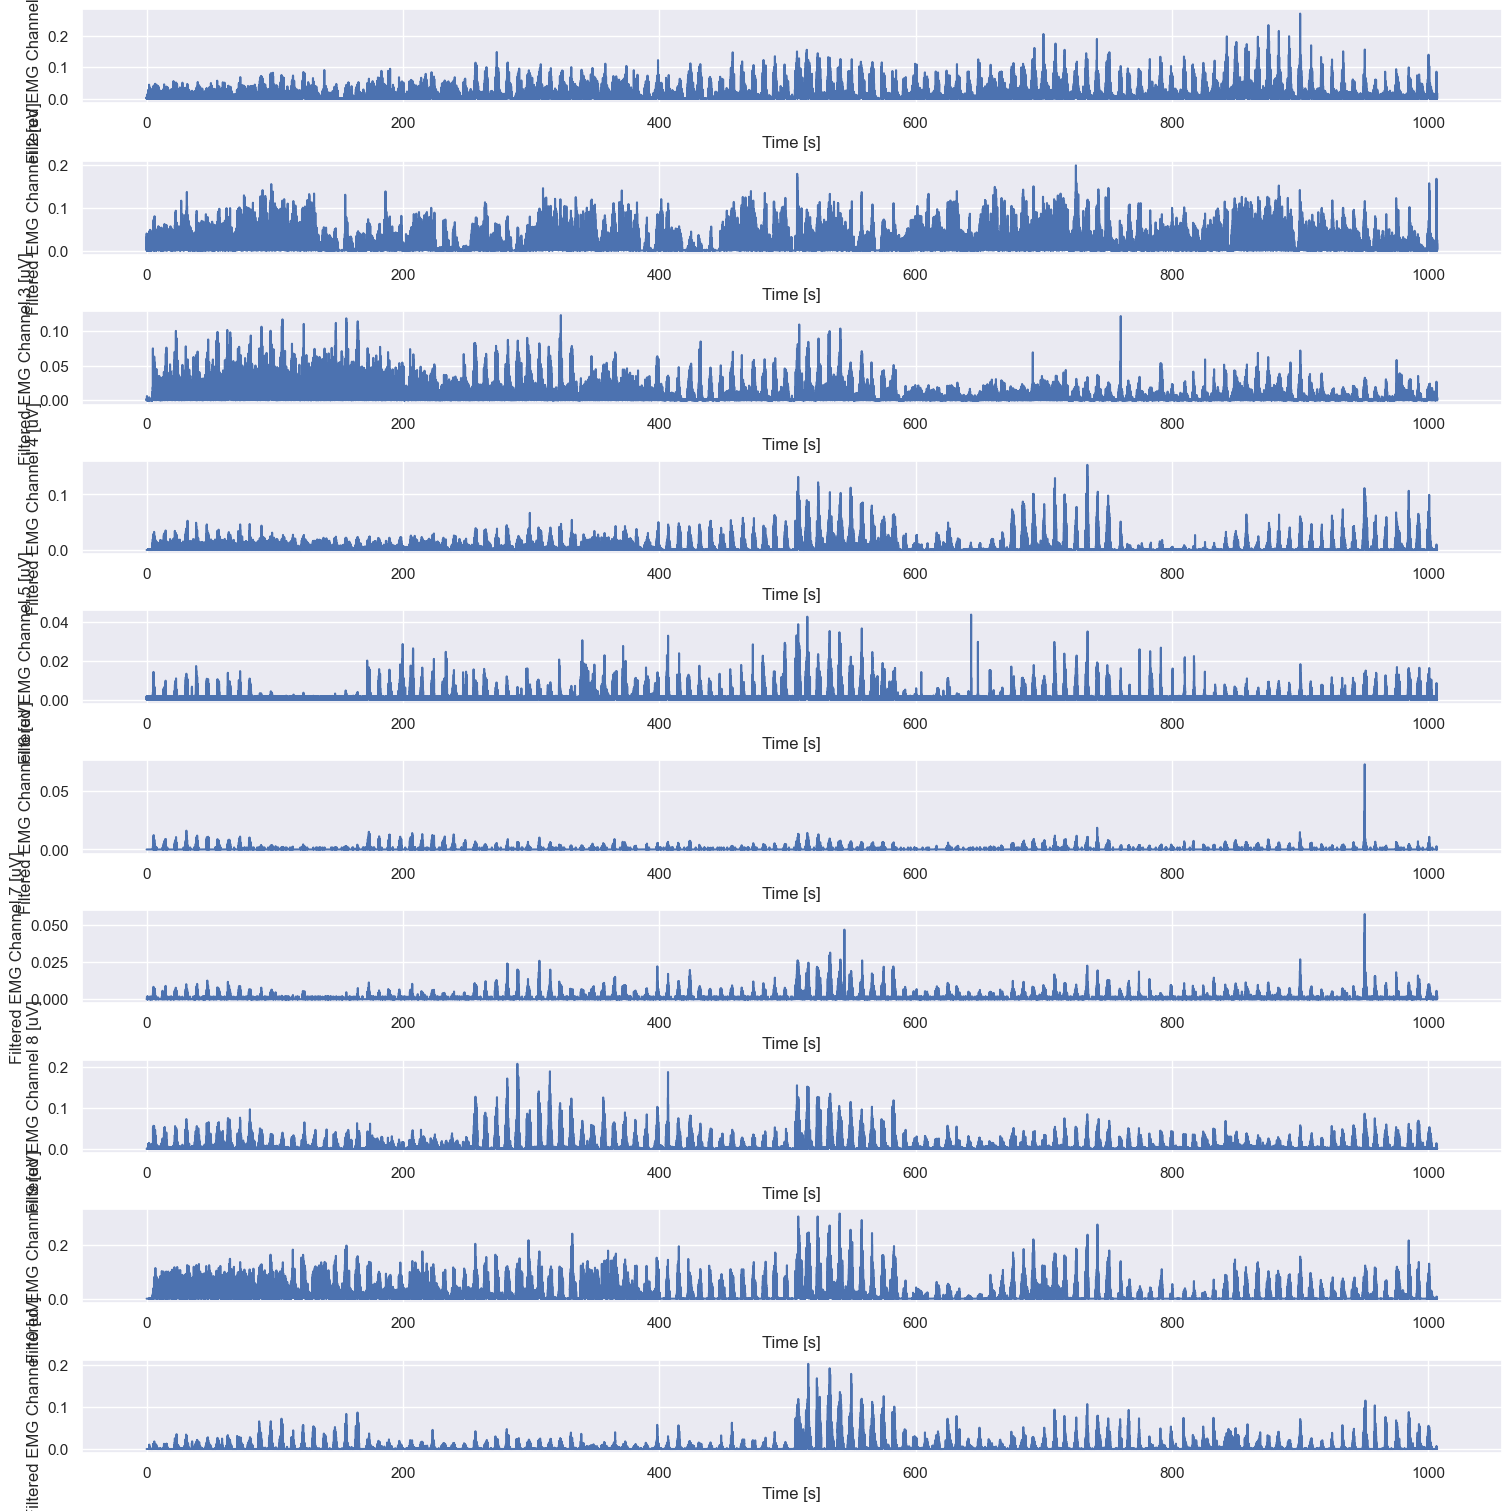

In [14]:
# Rectify the signal in order to better quantify the muscular activation.

emg_rectified = np.abs(emg_filtered)

fig, ax = plt.subplots(number_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(number_channels):
    ax[channel_idx].plot(time_steps, emg_rectified[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"Filtered EMG Channel {channel_idx + 1} [uV]")

plt.show()

"The classification procedure follows Englehart et al.19,37 and consists of pre-processing, **windowing (at 200 ms)**, feature extraction and classification." -paper electromyo. data for non-invasive blablabla


"In accordance with the classification strategy by Englehart and Hudgins [33], the filtered signals are segmented into windows, for which we consider an increment of 10 ms (i.e., 1 sample) and windows lengths of 100 ms, 200 ms, and 400 ms." - paper 1

"the optimal window length is dependent on both the classifier & feature representation, although **in the majority of cases the longer window length of 400 ms** is preferable." - paper 1

# 200 ms ou 400 ms??? 

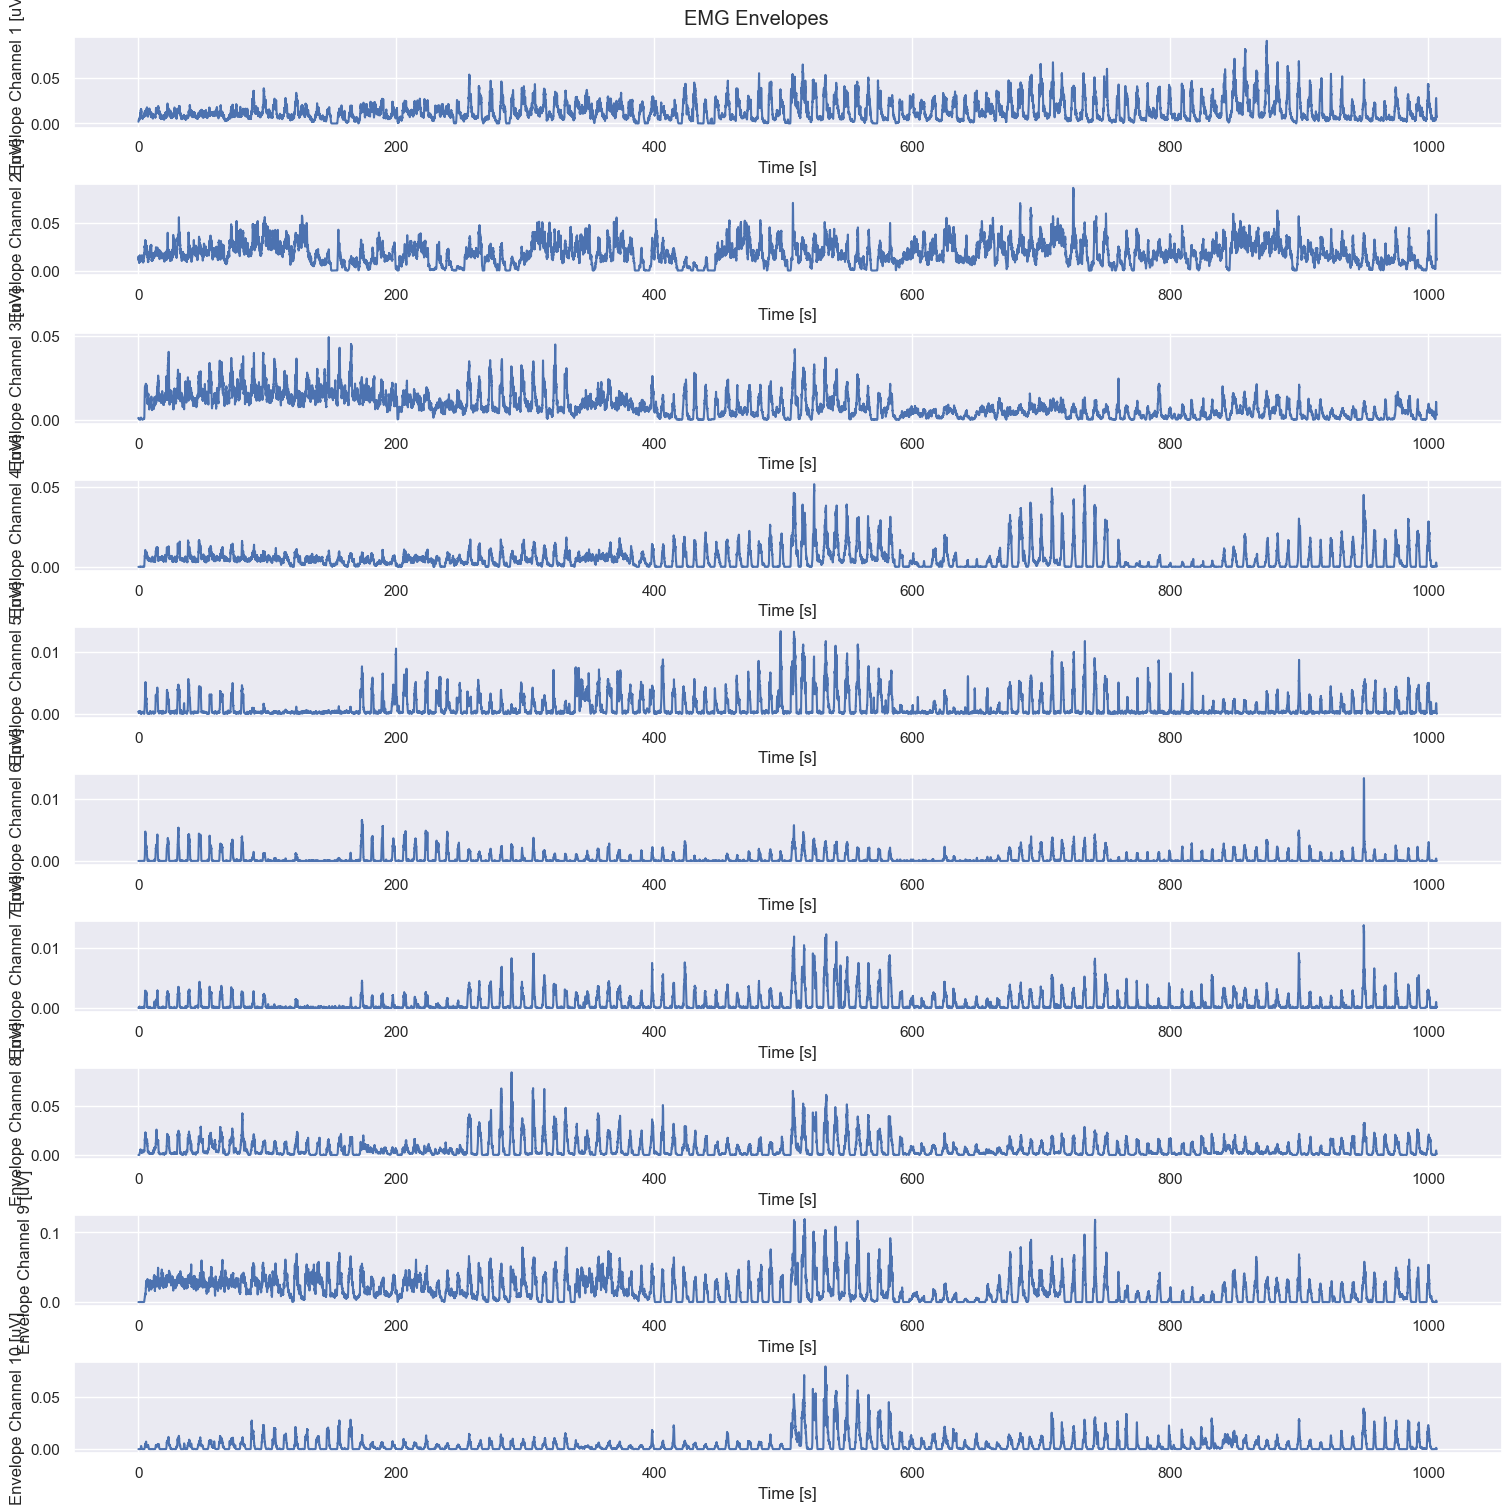

In [15]:
# compute the envelop of the signal by applying a moving average

mov_mean_size = int(fs * 0.4)  # For a 400 ms window --> if 200 ms: 0.2 not 0.4
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots(number_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(number_channels):
    ax[channel_idx].plot(time_steps, emg_envelopes[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"Envelope Channel {channel_idx + 1} [uV]")
plt.suptitle("EMG Envelopes")
plt.show()

## 2) Identifying bad trials

bad trials = constant 0 for one of the trial (in repetitions) while other trials had normal value + saturation of value

What we would like to see is the student plotting the data and perhaps having a for loop with some simple criteria (e.g. a for loop to check if any of window are purely 0).

### Determine nb of stimuli, repetitions, channels

In [27]:
# Exclude the rest class (label 0)
n_stimuli = len(np.unique(labels)) - 1  # Subtract 1 for rest class
n_repetitions = len(np.unique(repetition)) - 1  # Subtract 1 if repetitions start from 0
n_channels = emg_rectified.shape[1]

print(f'Number of stimuli (movements): {n_stimuli}')
print(f'Number of repetitions: {n_repetitions}')
print(f'Number of channels: {n_channels}')

print(f'Unique repetitions: {np.unique(repetition)}') # repetitions start from 0

Number of stimuli (movements): 12
Number of repetitions: 10
Number of channels: 10
Unique repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]


In [28]:
# nb of samples per trial

number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(1, n_stimuli + 1):  # Adjust index range if needed
    for repetition_idx in range(1, n_repetitions + 1):
        idx = np.logical_and(labels == stimuli_idx, repetition == repetition_idx)
        number_of_samples_per_trial[stimuli_idx - 1, repetition_idx - 1] = np.sum(idx)

print(number_of_samples_per_trial) # for the 120 trials

[[307. 390. 262. 226. 418. 204. 196. 270. 306. 489.]
 [334. 323. 344. 309. 333. 376. 362. 307. 348. 339.]
 [465. 352. 450. 460. 436. 389. 323. 388. 383. 316.]
 [310. 402. 357. 396. 255. 333. 263. 369. 438. 471.]
 [516. 382. 425. 379. 463. 411. 387. 343. 286. 377.]
 [337. 319. 337. 368. 338. 336. 268. 354. 319. 313.]
 [428. 392. 341. 393. 421. 445. 342. 328. 329. 358.]
 [289. 372. 406. 397. 498. 336. 415. 328. 472. 405.]
 [384. 424. 371. 316. 280. 314. 342. 284. 307. 421.]
 [311. 296. 299. 296. 301. 246. 213. 317. 493. 221.]
 [352. 403. 338. 416. 330. 355. 313. 322. 329. 219.]
 [270. 330. 300. 387. 295. 204. 363. 267. 281. 329.]]


The key step is windowing the data—whether you’re working with raw data or computing the envelope, either approach works. Once the data is windowed, you should have a structure like 10 repetitions × 12 stimuli × 10 channels or 120 trials × 10 channels.

In [30]:
# Define the window length in samples
window_length_ms = 400 # NOT SURE THE WINDOW IS OKAY???????? --> 400 should yield better results than 200 according to paper
mov_mean_length = int(fs * window_length_ms / 1000)
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# initialize data structures
emg_windows = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]
emg_envelopes = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

# segment data into trials & compute envelopes
for stimuli_idx in range(1, n_stimuli + 1):
    for repetition_idx in range(1, n_repetitions + 1):
        idx = np.logical_and(labels == stimuli_idx, repetition == repetition_idx)
        idx = idx.flatten()
        emg_window = emg_rectified[idx, :]
        emg_windows[stimuli_idx - 1][repetition_idx - 1] = emg_window
        
        # Compute the moving average (EMG envelope)
        emg_envelope = convolve1d(emg_window, mov_mean_weights, axis=0, mode='constant')
        emg_envelopes[stimuli_idx - 1][repetition_idx - 1] = emg_envelope

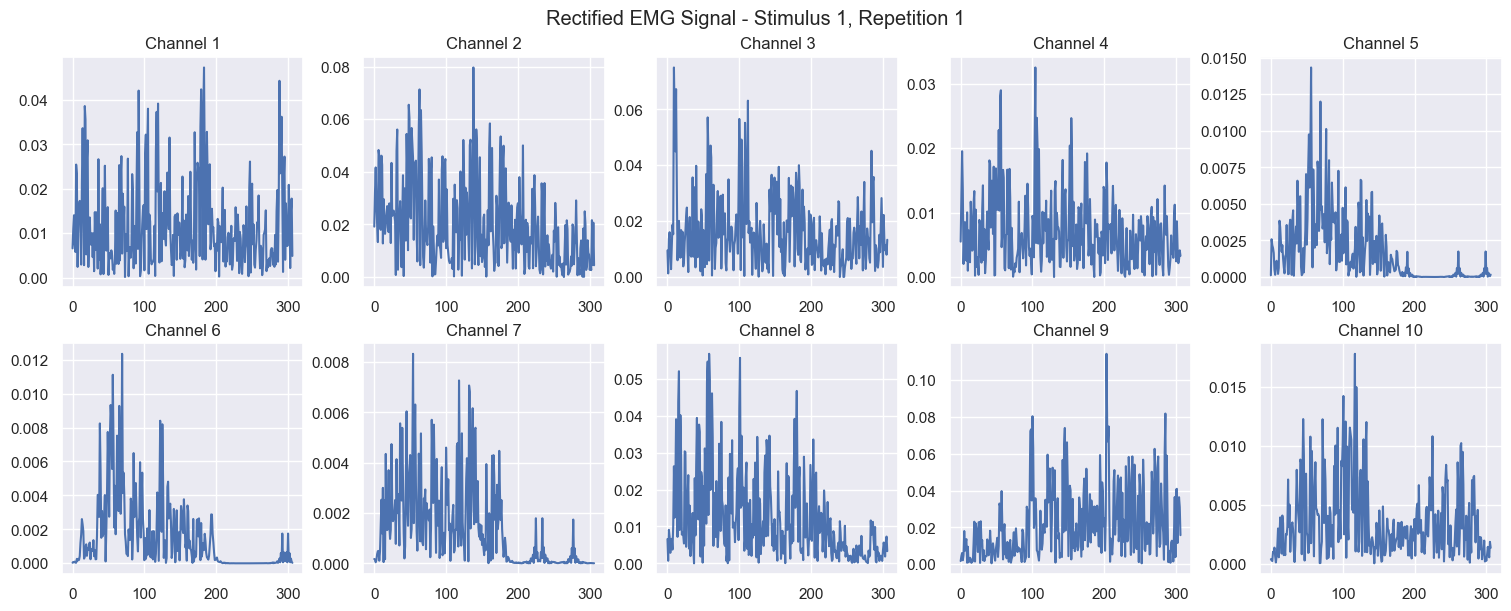

In [31]:
# plot rectified EMG signal for 1st stimulus & repetition

fig, ax = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
ax = ax.ravel()

for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
plt.suptitle("Rectified EMG Signal - Stimulus 1, Repetition 1")

plt.show()

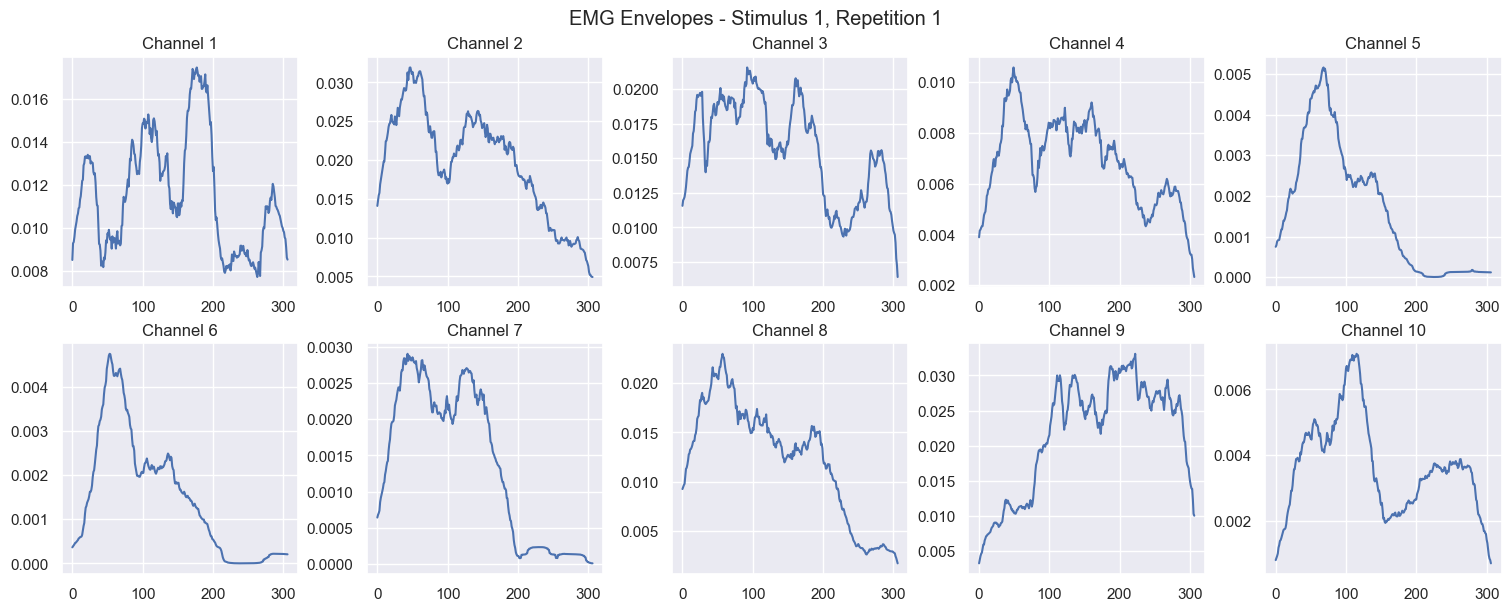

In [32]:
# plot EMG envelopes

fig, ax = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
ax = ax.ravel()

for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
plt.suptitle("EMG Envelopes - Stimulus 1, Repetition 1")
plt.show()

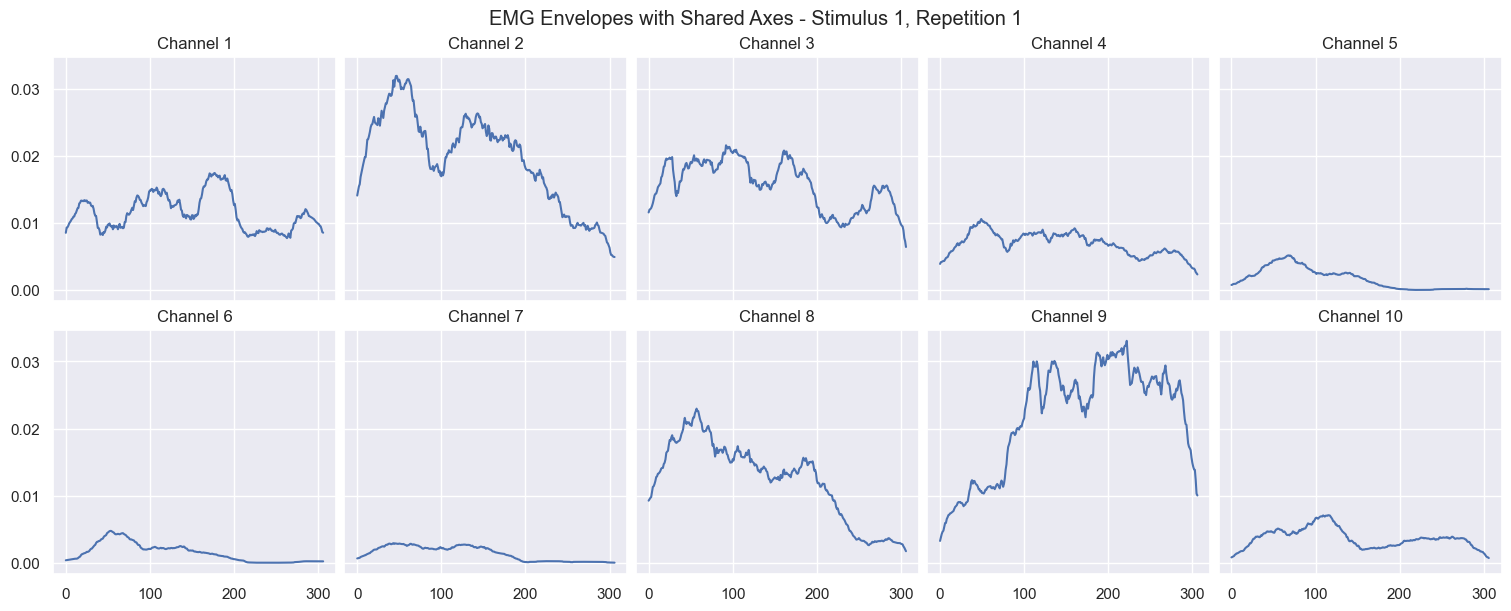

In [33]:
# shared axes to compare across channels --> same scale!!

fig, ax = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
plt.suptitle("EMG Envelopes with Shared Axes - Stimulus 1, Repetition 1")
plt.show()

Each channel = 1 muscle group
--> DON'T suppress channels

Each sitmulus = spe mov

Each repetition = 1 rep for each stimulus

In [34]:
bad_trials = []

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        trial_data = emg_windows[stimuli_idx][repetition_idx]
        
        # Check if all values in the trial are zero
        if np.all(trial_data == 0):
            bad_trials.append((stimuli_idx, repetition_idx))

print("Bad trials (completely zero):", bad_trials)

Bad trials (completely zero): []


In [38]:
saturated_trials = []
saturation_threshold_fraction = 0.1  # 10% threshold

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        trial_data = emg_windows[stimuli_idx][repetition_idx]
        
        # Identify the max and min values for the trial
        trial_max = np.max(trial_data)
        trial_min = np.min(trial_data)
        
        # Count how many samples are at max or min
        total_samples = trial_data.size
        max_count = np.sum(trial_data == trial_max)
        min_count = np.sum(trial_data == trial_min)
        
        # Compute fractions
        max_fraction = max_count / total_samples
        min_fraction = min_count / total_samples
        
        # Check if fraction exceeds the threshold
        if max_fraction > saturation_threshold_fraction or min_fraction > saturation_threshold_fraction:
            saturated_trials.append((stimuli_idx, repetition_idx))

print("Saturated trials:", saturated_trials)

Saturated trials: []


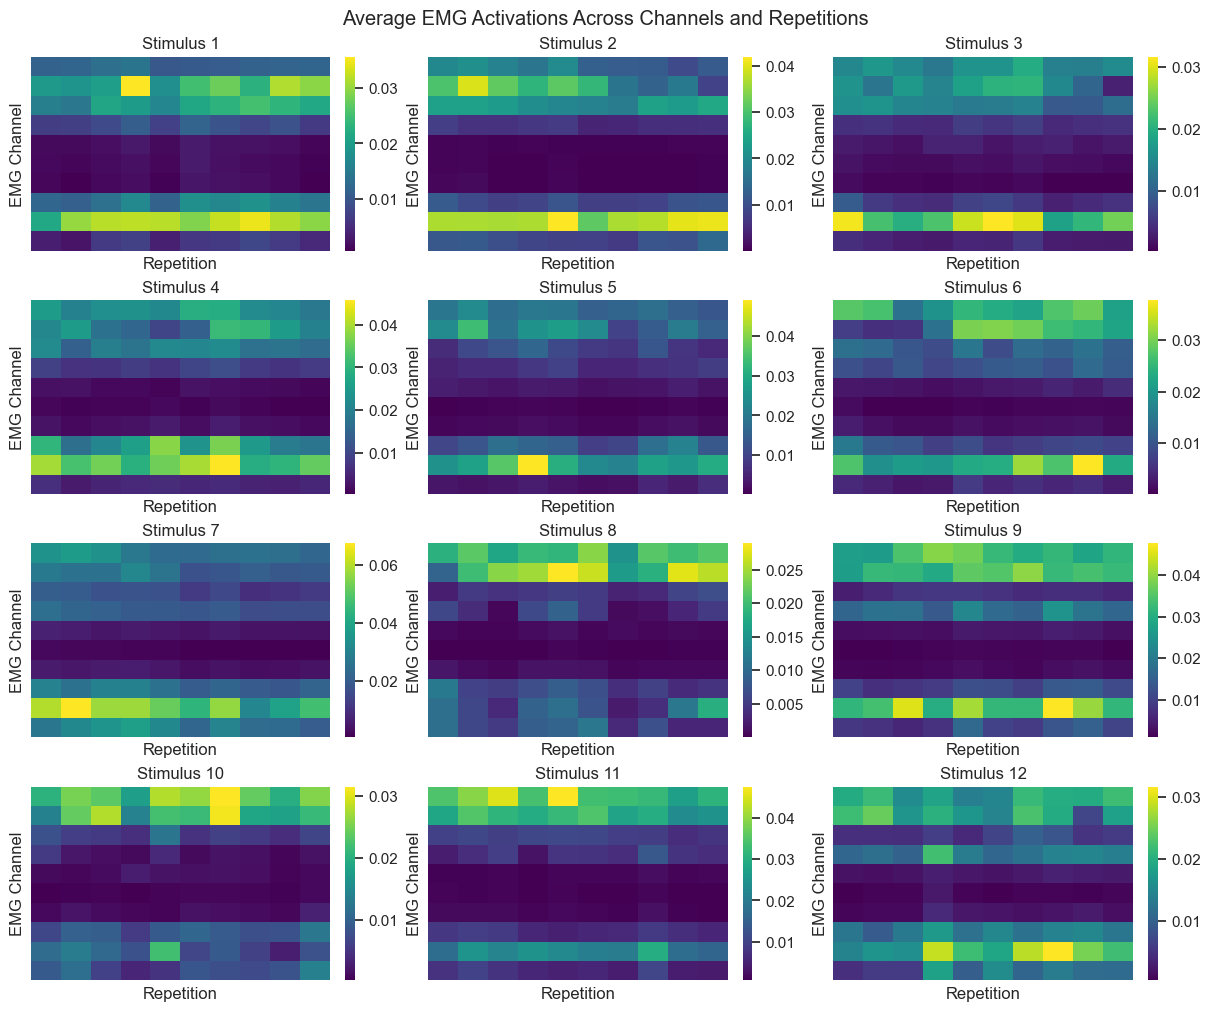

In [39]:
# compute average activations

emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        emg_envelope = emg_envelopes[stimuli_idx][repetition_idx]
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelope, axis=0)

fig, ax = plt.subplots(4, 3, figsize=(12, 10), constrained_layout=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(
        emg_average_activations[:, stimuli_idx, :],
        ax=ax[stimuli_idx],
        xticklabels=False,
        yticklabels=False,
        cbar=True,
        cmap='viridis'
    )
    ax[stimuli_idx].set_title(f"Stimulus {stimuli_idx + 1}")
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG Channel")
plt.suptitle("Average EMG Activations Across Channels and Repetitions")
plt.show()

The rows represent the activity recorded by each channel in response to repeated stimuli.
The columns correspond to each repetition of the stimulus. Variability across columns is expected due to several factors.

it appears that different stimuli elicit activation in different muscle groups. However, a more thorough analysis is required to confirm this observation. One approach could be to normalize the signals, making them more comparable across channels. This normalization would help in identifying specific patterns of muscle activation unique to each stimulus, providing deeper insights into the neuromuscular responses elicited by different stimuli.

# comment analyser ces trucs????!!!
bon y'a des groupes qui ont pas analysé

## 3) Splitting data into training, validation and testing sets & feature selection

splitting data: split data by the repetition so that the model can have at least some training data on each stimulus.

In [97]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    """
    Build the whole dataset
    """
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = 480 # DETERMINED THANKS TO THE CELL BELOW
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                feature_result = feature(emg[selected_tsteps, :])  # shape: (1, num_features_for_this_feature)
                num_feature_values = feature_result.shape[1]
                selected_features = np.arange(current_feature_index, current_feature_index + num_feature_values)
                dataset[current_sample_index, selected_features] = feature_result[0, :]
                current_feature_index += num_feature_values


            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

def build_dataset_from_ninapro_trials(emg, stimulus, repetition, features, trials):
    """
    Build dataset from specified (stimulus, repetition) trials only.
    """
    n_samples = len(trials)

    # Compute n_features by testing one trial
    s_test, r_test = trials[0]
    test_data = emg[(stimulus == s_test) & (repetition == r_test), :]
    n_features = 0
    for fn in features:
        test_result = fn(test_data)
        n_features += test_result.shape[1]

    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples, dtype=int)

    for idx, (s_val, r_val) in enumerate(trials):
        labels[idx] = s_val
        selected_tsteps = (stimulus == s_val) & (repetition == r_val)
        trial_data = emg[selected_tsteps, :]

        current_feature_index = 0
        for fn in features:
            feat_res = fn(trial_data)
            num_feat = feat_res.shape[1]
            dataset[idx, current_feature_index:current_feature_index + num_feat] = feat_res[0, :]
            current_feature_index += num_feat

    return dataset, labels

In [99]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)[np.newaxis, :]

# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)[np.newaxis, :]

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)[np.newaxis, :]

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))[np.newaxis, :]

# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)[np.newaxis, :]

# Slope sign changes (SSC)
def ssc(x, threshold=0):
    diff_signal = np.diff(x, axis=0)
    ssc_values = np.sum(((diff_signal[:-1] * diff_signal[1:]) < -threshold).astype(int), axis=0)
    return ssc_values[np.newaxis, :]
    
# zero crossing rate (ZCR): measures how often the signal changes its sign
def zcr(x):
    """
    Zero Crossing Rate (ZCR):
    Counts the number of times the signal crosses zero.
    We'll compute ZCR per channel.
    """
    n_channels = x.shape[1]
    zcr_values = []
    for ch in range(n_channels):
        ch_data = x[:, ch]
        # Sign changes occur where consecutive samples differ in sign
        sign_changes = ((ch_data[:-1] * ch_data[1:]) < 0).sum()
        zcr_values.append(sign_changes)
    # Shape: (n_channels,) -> make it (1, n_channels) for consistency
    return np.array(zcr_values)[np.newaxis, :]

# autoregressive coefficient (AR)
def ar(x, order=4):
    """
    Autoregressive (AR) coefficients using Yule-Walker equations.
    We'll fit an AR model of specified order for each channel and extract AR coefficients.

    yule_walker returns rho and sigma. rho are the AR parameters (positive sign).
    We'll return these AR coefficients as features.

    Note: AR model: x(t) + sum(a_k * x(t-k)) = noise
    Yule-Walker returns a_k with a sign, check documentation.
    """
    n_channels = x.shape[1]
    ar_coeff_matrix = []
    for ch in range(n_channels):
        ch_data = x[:, ch]
        rho, sigma = yule_walker(ch_data, order=order)
        ar_coeff_matrix.append(rho)
    # ar_coeff_matrix is shape (n_channels, order)
    ar_coeff_matrix = np.array(ar_coeff_matrix)  # shape: (n_channels, order)
    # Flatten to a 1D array: order*n_channels elements
    ar_flat = ar_coeff_matrix.flatten()  # shape: (n_channels*order,)
    # Return as shape (1, n_channels*order)
    return ar_flat[np.newaxis, :]

# marginal Discrete Wavelet Transform (mDWT)
def mdwt(x, wavelet='db7', level=3):
    """
    Computes marginal features from a multi-level Discrete Wavelet Transform (mDWT).
    For each channel:
    - Decompose the signal into approximation and detail coefficients up to `level`.
    - Compute the mean absolute value of coefficients for each sub-band.
    Returns a feature vector for each channel.
    """
    n_channels = x.shape[1]
    feature_list = []
    for ch in range(n_channels):
        ch_data = x[:, ch]
        coeffs = pywt.wavedec(ch_data, wavelet, level=level)
        ch_features = [np.mean(np.abs(c)) for c in coeffs]
        feature_list.extend(ch_features)  # Add them directly to a single list
    # Now feature_list is shape (n_subbands*n_channels,)
    return np.array(feature_list)[np.newaxis, :]

# Histogram (HIST)
def hist(x, bins=20):
    """
    Compute a histogram-based feature for each channel.
    We define the range as mean ± 3*std for each channel.
    Then we compute a histogram with `bins` bins.
    We return the histogram counts (normalized) as features.
    """
    n_channels = x.shape[1]
    feature_list = []
    for ch in range(n_channels):
        ch_data = x[:, ch]
        mean_val = np.mean(ch_data)
        std_val = np.std(ch_data)
        hist_range = (mean_val - 3*std_val, mean_val + 3*std_val)
        hist_counts, _ = np.histogram(ch_data, bins=bins, range=hist_range, density=True)
        feature_list.extend(hist_counts)
    return np.array(feature_list)[np.newaxis, :]

# Cepstral coefficients (CC)
def cc(x, n_ceps=13):
    """
    Compute cepstral coefficients for each channel.
    Steps:
    1. Compute FFT of the signal.
    2. Compute the log magnitude spectrum.
    3. Compute the inverse FFT (cepstrum).
    4. Take the first n_ceps coefficients (excluding the zeroth if desired).
    """
    n_channels = x.shape[1]
    feature_list = []
    for ch in range(n_channels):
        ch_data = x[:, ch]
        spectrum = rfft(ch_data)
        log_mag = np.log(np.abs(spectrum) + 1e-10)
        cepstrum = irfft(log_mag)
        cep_features = cepstrum[:n_ceps]
        feature_list.extend(cep_features)
    return np.array(feature_list)[np.newaxis, :]

In [ ]:
# TO DETERMINE THE NB OF FEATURES

features = [mav, std, maxav, rms, wl, ssc, zcr, ar, mdwt, hist, cc]
restimulus = data['restimulus'].flatten()

test_stim = 1
test_rep = 1
test_mask = (restimulus == test_stim) & (repetition == test_rep)
test_data = emg[test_mask, :]
print("test_data shape:", test_data.shape)

n_features = 0
for fn in features:
    test_result = fn(test_data)
    print(fn.__name__, "returned shape:", test_result.shape)
    n_features += test_result.shape[1]

print("Total number of features:", n_features)

In [107]:
# Identify number of stimuli and repetitions
n_stimuli = np.unique(restimulus).size - 1
n_repetitions = np.unique(repetition).size - 1

# Create a list of all trials (stimulus, repetition) pairs
all_trials = [(s+1, r+1) for s in range(n_stimuli) for r in range(n_repetitions)]
all_labels = [s+1 for s in range(n_stimuli) for r in range(n_repetitions)]

# Here, 30% of the data is reserved for testing, and 70% is used for training
X_train, X_test, y_train, y_test = train_test_split(all_trials, all_labels, test_size=0.3, stratify=all_labels)

# Define your features
features = [mav, std, maxav, rms, wl, ssc, zcr, ar, mdwt, hist, cc]

# Build training and test datasets from selected trials
X_train, y_train = build_dataset_from_ninapro_trials(emg, restimulus, repetition, features, X_train)
X_test, y_test = build_dataset_from_ninapro_trials(emg, restimulus, repetition, features, X_test)

print(f"Training dataset dimension: {X_train.shape}")
print(f"Training labels dimension: {y_train.shape}")
print(f"Testing dataset dimension: {X_test.shape}")
print(f"Testing labels dimension: {y_test.shape}")

Training dataset dimension: (84, 480)
Training labels dimension: (84,)
Testing dataset dimension: (36, 480)
Testing labels dimension: (36,)


In [ ]:
# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler

# Train a classifier on the normalized data -> GRADIENT BOOSTING
clf = GradientBoostingClassifier()
clf.fit(X_train_z, y_train)  # Fit the model on the training data

# Evaluate the classifier on the test set
# Predict the labels for the test set
y_pred = clf.predict(X_test_z)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification
# The confusion matrix shows the true vs predicted labels
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");

In [109]:
from collections import Counter

# assess class distribution to evaluate which metric is the most appropriate one

def assess_class_distribution(labels):
    # Count how many samples of each class
    class_counts = Counter(labels)
    total = len(labels)
    print("Class Distribution:")
    for cls, count in class_counts.items():
        percentage = (count / total) * 100
        print(f"Class {cls}: {count} samples ({percentage:.2f}%)")
    print()

# Assess class distribution in training set
print("Training set class distribution:")
assess_class_distribution(y_train)

# Assess class distribution in test set
print("Test set class distribution:")
assess_class_distribution(y_test)

Training set class distribution:
Class Distribution:
Class 11: 7 samples (8.33%)
Class 10: 7 samples (8.33%)
Class 1: 7 samples (8.33%)
Class 6: 7 samples (8.33%)
Class 8: 7 samples (8.33%)
Class 9: 7 samples (8.33%)
Class 4: 7 samples (8.33%)
Class 7: 7 samples (8.33%)
Class 3: 7 samples (8.33%)
Class 2: 7 samples (8.33%)
Class 12: 7 samples (8.33%)
Class 5: 7 samples (8.33%)

Test set class distribution:
Class Distribution:
Class 4: 3 samples (8.33%)
Class 5: 3 samples (8.33%)
Class 6: 3 samples (8.33%)
Class 7: 3 samples (8.33%)
Class 11: 3 samples (8.33%)
Class 3: 3 samples (8.33%)
Class 8: 3 samples (8.33%)
Class 10: 3 samples (8.33%)
Class 12: 3 samples (8.33%)
Class 2: 3 samples (8.33%)
Class 9: 3 samples (8.33%)
Class 1: 3 samples (8.33%)



Mean of each feature across all training trials:
[ 7.96823331e-01  5.11215660e-01  2.91333360e-01  2.45483401e-01
  3.31710746e-02  1.20632378e-02  2.50177990e-02  3.71892998e-01
  6.58445849e-01  1.99531963e-01  3.26092823e-01  1.98191744e-01
  1.27765385e-01  1.51297871e-01  2.96267230e-02  1.26241853e-02
  2.37014569e-02  2.16567495e-01  3.32248013e-01  1.38122852e-01
  1.49190238e+00  1.00175714e+00  6.11869048e-01  5.95096429e-01
  1.28530952e-01  5.69142857e-02  9.71035714e-02  8.59551190e-01
  1.42357143e+00  5.48271429e-01  8.65648113e-01  5.53795679e-01
  3.21362821e-01  2.91804903e-01  4.51421683e-02  1.77486646e-02
  3.47689719e-02  4.33120737e-01  7.45673152e-01  2.45326916e-01
  1.09816929e+01  1.09683155e+01  5.82985357e+00  4.40146548e+00
  1.05831429e+00  3.97778571e-01  8.00327381e-01  6.06646548e+00
  1.30939798e+01  4.25663095e+00  9.28333333e+01  9.27500000e+01
  7.83690476e+01  6.39523810e+01  3.64523810e+01  1.70119048e+01
  2.96785714e+01  7.30952381e+01  8.04166

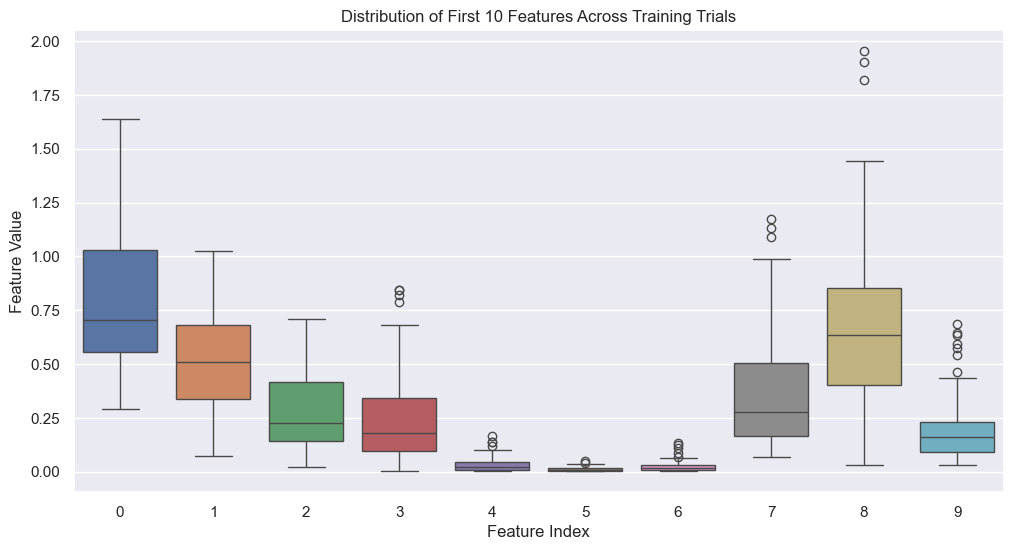

In [110]:
# analysis of typical feature values --> PAS SÛRE QU'IL FAILLE FAIRE ÇA POUR LES ANALYSER
# quoi d'autre?????????

feature_means = np.mean(X_train, axis=0)
feature_stds = np.std(X_train, axis=0)

print("Mean of each feature across all training trials:")
print(feature_means)
print("Standard deviation of each feature across all training trials:")
print(feature_stds)

# To visualize, pick a subset of features (e.g., first 10) and plot boxplots
# This can give insight into the distribution of feature values across trials.
num_features_to_plot = 10
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train[:, :num_features_to_plot])
plt.title("Distribution of First 10 Features Across Training Trials")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()

Each class is equally represented in the dataset so the accuracy metric is appropriate.

Linear classifier (like LDA) perform poorly bc don't scale to a large nb of postures.

SVM & MLP = similar max perf --> SVM high perf w/all features

#### Features selection:

- **PAPER ON ELECTROMYO. DATA FOR NON-INVASIVE BLABLA (use them with SVM, k-NN, random forests):** "The selected signal features are: Root-Mean-Square (RMS), the time domain statistics described by Hudgins et al.38 (TD), Histogram (HIST), marginal Discrete Wavelet Transform (mDWT) and the normalized combination of all of the above. All the features have been applied successfully to myoelectric signals19,34,37. While using Histogram (HIST)39, the histogram was divided into 20 bins along a 3σ threshold. For the marginal Discrete Wavelet Transform (mDWT), we used a db7 wavelet with three levels"
- **PAPER CHARACTERIZATION OF A BENCHMARK DATABASE BLABLA (use them with kNN, LDA, SVM, MLP):** Mean absolute value (MAV), variance (VAR), waveform length (WL), histogram (HIST), cespstral coeff (CC), short-time fourier transform (STFT), marginal discrete wavelet transform (mDWT)
- **PAPER 3 (use them with LS-SVM):** not mentioned

## 4) Hyperparameter tuning (CROSS-VALIDATION)

In [94]:
# Perform cross-validation

# 'clf' is your classifier, 'X_train_z' is the normalized training data, 'y_train' are the training labels
scores = cross_val_score(clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

Accuracy scores of all models: [0.82352941 0.52941176 0.52941176 0.64705882 0.5625    ]
Mean accuracy across all models: 0.6183823529411765


Accuracy scores of all models: [0.82352941 0.52941176 0.52941176 0.64705882 0.5625    ]
Mean accuracy across all models: 0.6183823529411765

In [95]:
# Use cross-validation to find the best hyperparameters for GRADIENT BOOSTING

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV with the classifier and parameter grid
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)
grid.fit(X_train_z, y_train)

best_estim = grid.best_estimator_
best_par = grid.best_params_

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

# Predict the labels for the test set using the best estimator
y_pred = grid.predict(X_test_z)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of best model: {accuracy}") 

Best estimator: GradientBoostingClassifier(learning_rate=0.05, n_estimators=200)
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Accuracy score of best model: 0.3888888888888889


Best estimator: GradientBoostingClassifier(learning_rate=0.05, n_estimators=200)
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Accuracy score of best model: 0.3888888888888889

## 6) Feature selection

In [121]:
from sklearn.decomposition import PCA

# Method A: PCA

pca = PCA(n_components=36)
X_train_pca = pca.fit_transform(X_train_z)
X_test_pca = pca.transform(X_test_z)

clf_pca = GradientBoostingClassifier()
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
pca_accuracy = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy after PCA (36 components): {pca_accuracy:.4f}")

Accuracy after PCA (36 components): 0.1667


Accuracy after PCA (36 components): 0.1667

Estimated mutual information between each feature and the target:
 [0.00000000e+00 0.00000000e+00 1.00598594e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.27235986e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.56081890e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.41299675e-02 0.00000000e+00
 6.18317869e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.73159470e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.31379134e-03 4.70117868e-02 0.00000000e+00 2.18761683e-02
 2.60259744e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.10545608e-01 0.00000000e+00
 0.00000000e+00 2.36876958e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.35030224e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.73125147e-02 0.

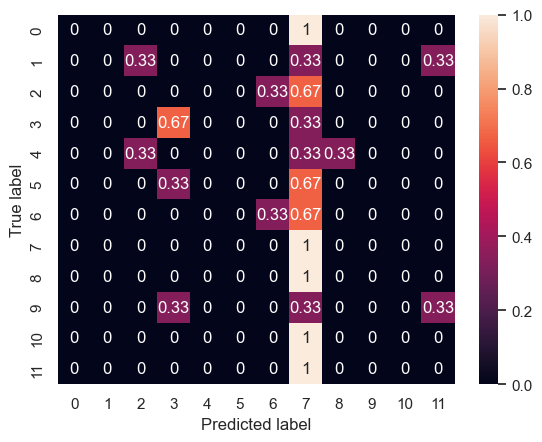

In [127]:
# Method B: SelectKBest

# Calculate mutual information between each feature and the target variable.
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

# Select the top 10 features based on mutual information scores.
k_best = SelectKBest(mutual_info_classif, k=19)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

# Initialize the classifier with the best parameters found earlier --> CHANGE TO GRADIENT BOOSTING!!!
clf_kbest = GradientBoostingClassifier(**grid.best_params_)  # Use the best parameters found before
clf_kbest.fit(X_train_best, y_train)

# Predict the labels for the test set using the trained model.
y_pred = clf_kbest.predict(X_test_best)

# Calculate the accuracy of the model with the selected features.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of a model with k best features: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification model.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.

fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

Accuracy score of a model with k best features: 0.16666666666666666

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Assume X_train, X_test, y_train, y_test are defined
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z = scaler.transform(X_test)

# L1 regularized logistic regression for feature selection
logreg = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, C=0.1, random_state=42)
logreg.fit(X_train_z, y_train)

# Coefficients that are zero mean those features are not selected
coef = logreg.coef_[0]
selected_features = np.where(coef != 0)[0]  # Features with non-zero coefficients

X_train_l1 = X_train_z[:, selected_features]
X_test_l1 = X_test_z[:, selected_features]

clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train_l1, y_train)
y_pred = clf.predict(X_test_l1)
print("L1-based Feature Selection Accuracy:", accuracy_score(y_test, y_pred))
print("Number of selected features:", len(selected_features))

L1-based Feature Selection Accuracy: 0.2222222222222222
Number of selected features: 5


L1-based Feature Selection Accuracy: 0.2222222222222222
Number of selected features: 5

In [129]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier

# You can use an estimator for RFE
estimator = GradientBoostingClassifier(random_state=42)
# Choose a number of features to keep, e.g. 30
rfe = RFE(estimator, n_features_to_select=30, step=1)
rfe.fit(X_train_z, y_train)

X_train_rfe = rfe.transform(X_train_z)
X_test_rfe = rfe.transform(X_test_z)

clf_rfe = GradientBoostingClassifier(random_state=42)
clf_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = clf_rfe.predict(X_test_rfe)
print("RFE Accuracy:", accuracy_score(y_test, y_pred_rfe))
print("Number of selected features:", np.sum(rfe.support_))

RFE Accuracy: 0.4444444444444444
Number of selected features: 30


RFE Accuracy: 0.4444444444444444
Number of selected features: 30